**Ann Classification**


In [3]:
from sklearn.calibration import LabelEncoder
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset


In [4]:
data = pd.read_csv("loan_data.csv")
targets = data['loan_status']

data.drop('loan_status', axis=1, inplace=True)

In [5]:
encoder = LabelEncoder()
data["person_gender"] = encoder.fit_transform(data['person_gender'])
data["person_education"] = encoder.fit_transform(data['person_education'])
data["person_home_ownership"] = encoder.fit_transform(data['person_home_ownership'])
data["loan_intent"] = encoder.fit_transform(data['loan_intent'])
data['previous_loan_defaults_on_file'] = encoder.fit_transform(data['previous_loan_defaults_on_file'])

In [16]:
scaler = StandardScaler()
data = scaler.fit_transform(data)
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
data_balanced, targets_balanced = ros.fit_resample(data, targets)





(70000, 13)


In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(data_balanced, targets_balanced, test_size=0.2, random_state=42)
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
X_validation = torch.FloatTensor(X_validation)
Y_train = torch.LongTensor(Y_train.values)
Y_validation = torch.LongTensor(Y_validation.values)
Y_test = torch.LongTensor(Y_test.values)

In [19]:
class Classification(nn.Module):
    def __init__(self, input_dim, hidden1, hidden2, hidden3, output_dim):
        super(Classification, self).__init__()
        self.W1 = nn.Parameter(torch.randn(input_dim, hidden1,requires_grad=True) * 0.01)
        self.b1 = nn.Parameter(torch.zeros(hidden1))
        self.W2 = nn.Parameter(torch.randn(hidden1, hidden2,requires_grad=True) * 0.01)
        self.b2 = nn.Parameter(torch.zeros(hidden2,))
        self.W3 = nn.Parameter(torch.randn(hidden2, hidden3,requires_grad=True) * 0.01)
        self.b3 = nn.Parameter(torch.zeros(hidden3))
        self.W_out = nn.Parameter(torch.randn(hidden3, output_dim,requires_grad=True) * 0.01)
        self.b_out = nn.Parameter(torch.zeros(output_dim))
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, X):
        x = self.relu(torch.mm(X, self.W1) + self.b1)
        x = self.relu(torch.mm(x, self.W2) + self.b2)
        x = self.relu(torch.mm(x, self.W3) + self.b3)
        x = self.sigmoid(torch.mm(x, self.W_out) + self.b_out)
        return x

In [20]:
output_dim = len(targets.unique())
input_dim = X_train.shape[1]
hidden1 = 10
hidden2 = 19
hidden3 = 20

In [21]:
model = Classification(input_dim, hidden1, hidden2, hidden3, output_dim)

criterion = nn.CrossEntropyLoss()
learning_rate = 0.01

In [22]:
# %%
batch_size=32
epochs = 30
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

val_losses = []
accuracies = []
train_losses = []
train_data = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

val_data = TensorDataset(X_validation, Y_validation)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
def train_model(epochs):
    for epoch in range(epochs):
        model.train()
        batch_loss = 0
        correct = 0
        total = 0
        for x_batch, y_batch in train_loader:
            yhat = model(x_batch)
            loss = criterion(yhat, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batch_loss += loss.item()
            _, predicted = torch.max(yhat, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
        train_loss = batch_loss / len(train_loader)
        train_losses.append(train_loss)
        accuracy = correct / total
        accuracies.append(accuracy)
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                yhat = model(x_batch)
                loss = criterion(yhat, y_batch)
                val_loss += loss.item()  # Accumulate validation loss
                _, predicted = torch.max(yhat, 1)
                val_correct += (predicted == y_batch).sum().item()
                val_total += y_batch.size(0)

        val_loss /= len(val_loader)  # Average validation loss
        val_losses.append(val_loss)
        val_accuracy = val_correct / val_total  # Validation accuracy

        # Print epoch progress
        print(f"Epoch {epoch + 1}/{epochs}:")
        print(f"    Training Loss: {train_loss:.4f}, Accuracy: {accuracy:.4f}")
        print(f"    Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")


train_model(epochs)



Epoch 1/30:
    Training Loss: 0.4545, Accuracy: 0.8661
    Validation Loss: 0.4412, Accuracy: 0.8698
Epoch 2/30:
    Training Loss: 0.4257, Accuracy: 0.8818
    Validation Loss: 0.4295, Accuracy: 0.8761
Epoch 3/30:
    Training Loss: 0.4229, Accuracy: 0.8832
    Validation Loss: 0.4281, Accuracy: 0.8782
Epoch 4/30:
    Training Loss: 0.4226, Accuracy: 0.8822
    Validation Loss: 0.4243, Accuracy: 0.8812
Epoch 5/30:
    Training Loss: 0.4214, Accuracy: 0.8850
    Validation Loss: 0.4232, Accuracy: 0.8833
Epoch 6/30:
    Training Loss: 0.4212, Accuracy: 0.8846
    Validation Loss: 0.4231, Accuracy: 0.8813
Epoch 7/30:
    Training Loss: 0.4198, Accuracy: 0.8854
    Validation Loss: 0.4209, Accuracy: 0.8821
Epoch 8/30:
    Training Loss: 0.4196, Accuracy: 0.8855
    Validation Loss: 0.4263, Accuracy: 0.8772
Epoch 9/30:
    Training Loss: 0.4190, Accuracy: 0.8865
    Validation Loss: 0.4191, Accuracy: 0.8835
Epoch 10/30:
    Training Loss: 0.4177, Accuracy: 0.8891
    Validation Loss: 0.41

In [ ]:
model.eval()
with torch.no_grad():
    logits = model(X_test)
    predicted_classes = torch.argmax(logits, dim=1)
    accuracy = accuracy_score(Y_test, predicted_classes)
    f1_score = f1_score(Y_test, predicted_classes)
    percision_score = precision_score(Y_test, predicted_classes)
    recall_score = recall_score(Y_test, predicted_classes)
    confusion_matrix = confusion_matrix(Y_test, predicted_classes)

    print(predicted_classes)
    print(Y_test)

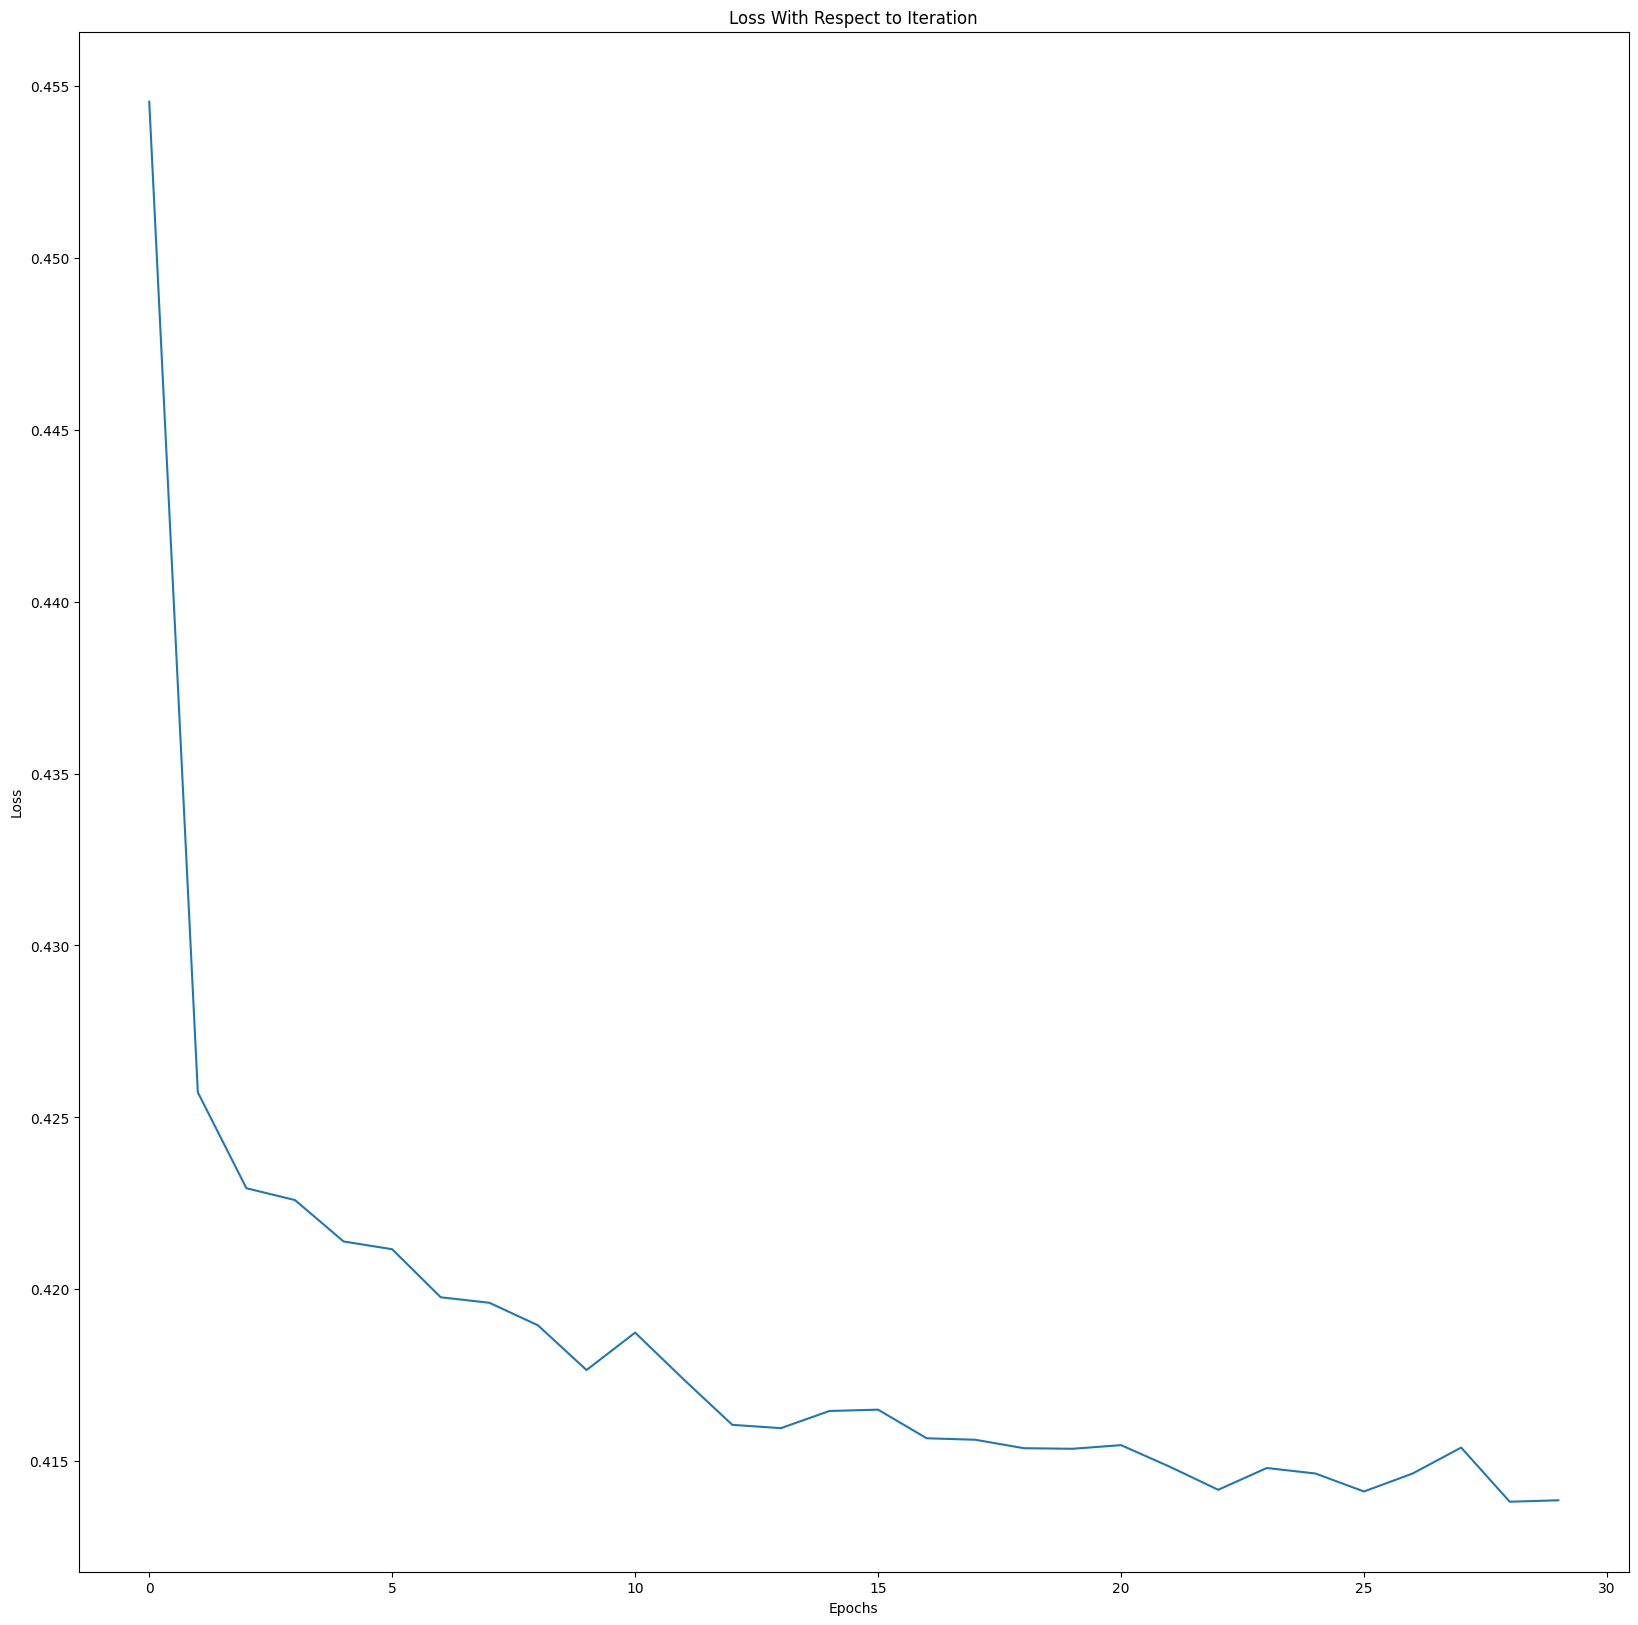

In [23]:
import matplotlib.pyplot as plt
loss_values = [l for l in train_losses]
plt.figure(figsize=(20, 20))
plt.title("Loss With Respect to Iteration")
plt.plot(range(len(loss_values)), loss_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

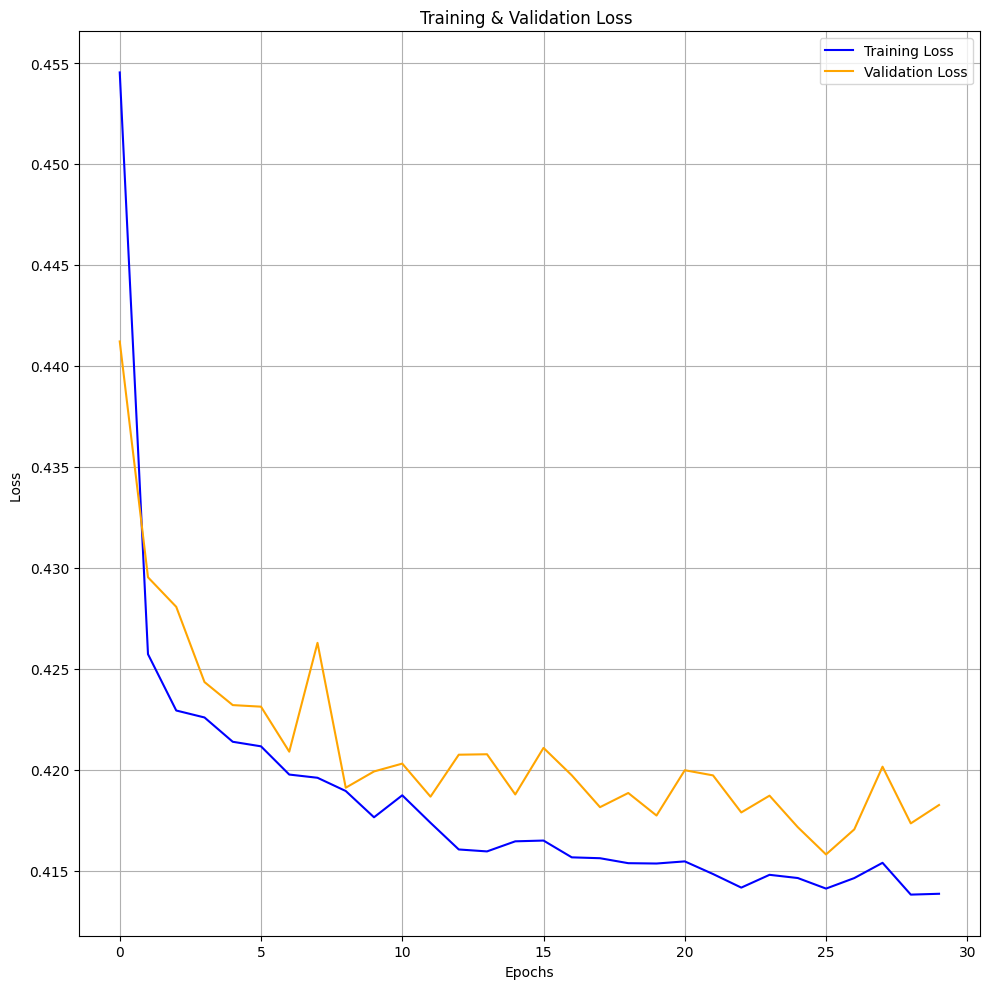

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.plot(range(len(train_losses)), train_losses, label='Training Loss', color='blue')
plt.plot(range(len(train_losses)), val_losses, label='Validation Loss', color='orange')

plt.xlabel('Epochs')
plt.ylabel('Loss ')
plt.title('Training & Validation Loss ')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


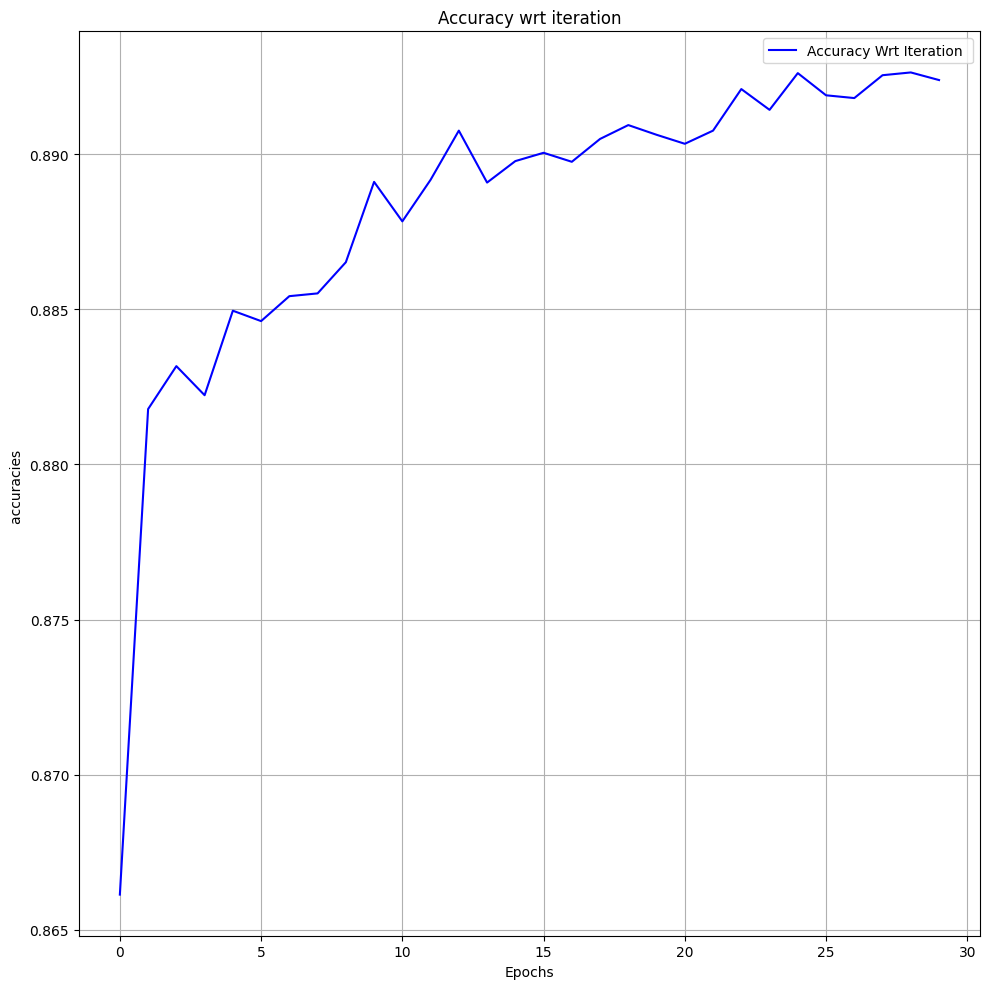

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.plot(range(len(accuracies)), accuracies, label='Accuracy Wrt Iteration ', color='blue')

plt.xlabel('Epochs')
plt.ylabel('accuracies ')
plt.title('Accuracy wrt iteration')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()